# Attention Walmart Shoppers
### A Walmart retail analysis

The data was originally retrieved from:
 -   https://www.kaggle.com/rutuspatel/retail-analysis-with-walmart-sales-data
 - https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data

### Data Dictionary

| Target       |  Data Type       | Description                     |
|--------------|------------------|---------------------------------|
| Weekly_Sales |   float64        | Sales in USD per week by store  |


| Column        |  Data Type       | Description                                      |  
|---------------|------------------|--------------------------------------------------|
| Store         |     int64        | unique identifier for store  (1-45)              |
| Date          |     object       | Date of transaction                              |
| Holiday_Flag  |     int64        | indicator of a Holiday week (boolean)            |
| Temperature   |     float64      | temperature in Farenheight                       |
| Fuel_Price    |     float64      | cost of fuel(in USD) in region                   |
| CPI           |     float64      | Prevailing consumer price index, cost of goods   |
| Unemployment  |     float64      | Prevailing unemployment rate                     |

## Goal:
- to predict weekly sales price for a store

## Think about...
- What is your goal?
- what is your TARGET? drivers for that target?
- what is one oberservation? what does one row from your dataset represent?

## Daily meetings
- standup doc
- shared knowledge doc

### Three important Questions
- what did you work on since we last talked?
- what are you planning on working on next?
- what are your blockers?

In [1]:
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#math
from scipy import stats
import math

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score

#custom modules
import new_wrangle as w

#remove warnings
import warnings
warnings.filterwarnings("ignore")

<hr style="border:2px solid black"> </hr>

# Acquire

In [2]:
#bring in walmart data using new_wrangle.py
df= w.acquire_data()

In [3]:
#take a look
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106,A,151315
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106,A,151315
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106,A,151315
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106,A,151315
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106,A,151315


In [4]:
#check for nulls, dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6435 entries, 0 to 6434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
 8   Type          6435 non-null   object 
 9   Size          6435 non-null   int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 553.0+ KB


<hr style="border:2px solid black"> </hr>

# Prepare

In [5]:
#import the cleaned data using new_wrangle.py
df= w.wrangle_walmart()

In [6]:
#make sure that all columns are created
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6435 entries, 2010-02-05_store_1_2010-02-12 to 2012-10-26_store_45_nan
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   store_id                6435 non-null   object        
 1   this_week_date          6435 non-null   datetime64[ns]
 2   this_week_sales         6435 non-null   float64       
 3   this_week_holiday_flag  6435 non-null   int64         
 4   this_week_unemployment  6435 non-null   float64       
 5   store_type              6435 non-null   object        
 6   store_size              6435 non-null   int64         
 7   next_week_1_year_ago    4140 non-null   float64       
 8   next_week_sales_target  6390 non-null   float64       
 9   next_week_date          6390 non-null   datetime64[ns]
 10  next_week_holiday_flag  6390 non-null   float64       
 11  next_week_holiday_name  6435 non-null   object        
 12  christ

In [7]:
#take a look at the data
df.tail().T

id,2012-09-28_store_45_2012-10-05,2012-10-05_store_45_2012-10-12,2012-10-12_store_45_2012-10-19,2012-10-19_store_45_2012-10-26,2012-10-26_store_45_nan
store_id,45,45,45,45,45
this_week_date,2012-09-28 00:00:00,2012-10-05 00:00:00,2012-10-12 00:00:00,2012-10-19 00:00:00,2012-10-26 00:00:00
this_week_sales,713174,733455,734464,718126,760281
this_week_holiday_flag,0,0,0,0,0
this_week_unemployment,8.684,8.667,8.667,8.667,8.667
store_type,B,B,B,B,B
store_size,118221,118221,118221,118221,118221
next_week_1_year_ago,753447,720947,771686,781695,833429
next_week_sales_target,733455,734464,718126,760281,NaN
next_week_date,2012-10-05 00:00:00,2012-10-12 00:00:00,2012-10-19 00:00:00,2012-10-26 00:00:00,NaT


In [8]:
df.isnull().sum()

store_id                     0
this_week_date               0
this_week_sales              0
this_week_holiday_flag       0
this_week_unemployment       0
store_type                   0
store_size                   0
next_week_1_year_ago      2295
next_week_sales_target      45
next_week_date              45
next_week_holiday_flag      45
next_week_holiday_name       0
christmas                    0
labor_day                    0
pre_christmas                0
super_bowl                   0
thanksgiving                 0
dtype: int64

In [9]:
#train test split
train, test = w.split_scale(df,'next_week_sales_target')

train -> (2866, 17)
test -> (1229, 17)


In [10]:
#take a look
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6435 entries, 2010-02-05_store_1_2010-02-12 to 2012-10-26_store_45_nan
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   store_id                6435 non-null   object        
 1   this_week_date          6435 non-null   datetime64[ns]
 2   this_week_sales         6435 non-null   float64       
 3   this_week_holiday_flag  6435 non-null   int64         
 4   this_week_unemployment  6435 non-null   float64       
 5   store_type              6435 non-null   object        
 6   store_size              6435 non-null   int64         
 7   next_week_1_year_ago    4140 non-null   float64       
 8   next_week_sales_target  6390 non-null   float64       
 9   next_week_date          6390 non-null   datetime64[ns]
 10  next_week_holiday_flag  6390 non-null   float64       
 11  next_week_holiday_name  6435 non-null   object        
 12  christ

<hr style="border:2px solid black"> </hr>

# Explore

In [11]:
#count of season
#train.season.value_counts()

In [12]:
#counts by holidays
train.next_week_holiday_name.value_counts()

no_holiday       2615
labor_day          66
super_bowl         63
pre_christmas      60
christmas          31
thanksgiving       31
Name: next_week_holiday_name, dtype: int64

## bivariate exploration

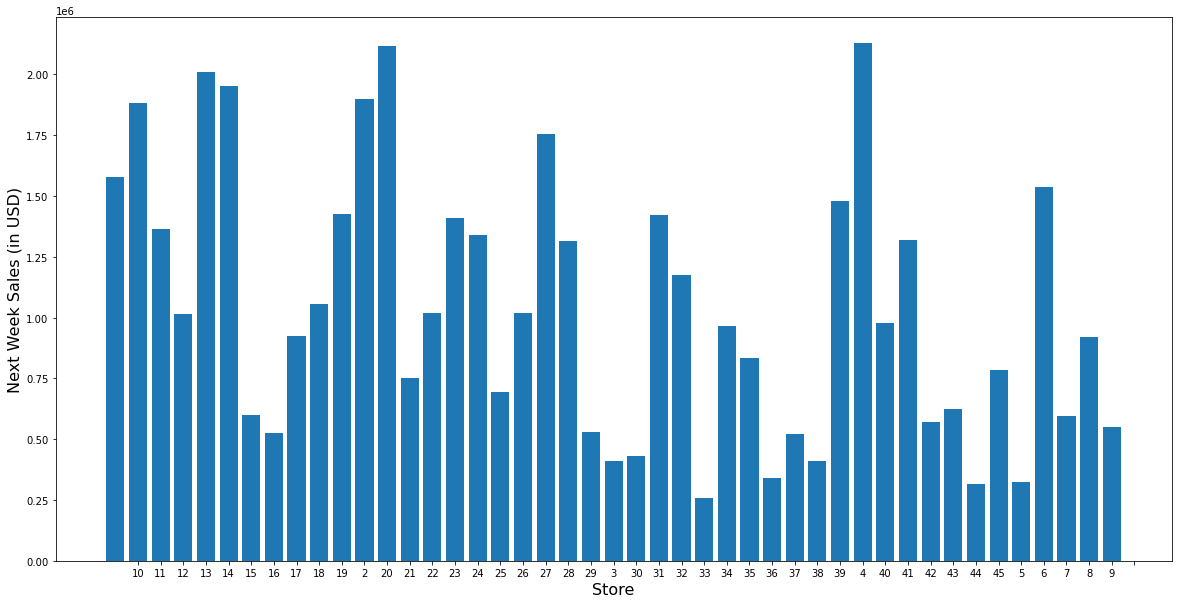

In [13]:
#average weekly sales by store
stores = train.groupby(['store_id']).agg({'next_week_sales_target': ['mean']})

plt.figure(figsize=(20, 10))
plt.bar(stores.index,stores['next_week_sales_target']['mean'])
plt.xticks(np.arange(1, 46, step=1))
plt.ylabel('Next Week Sales (in USD)', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

<AxesSubplot:xlabel='store_type', ylabel='store_size'>

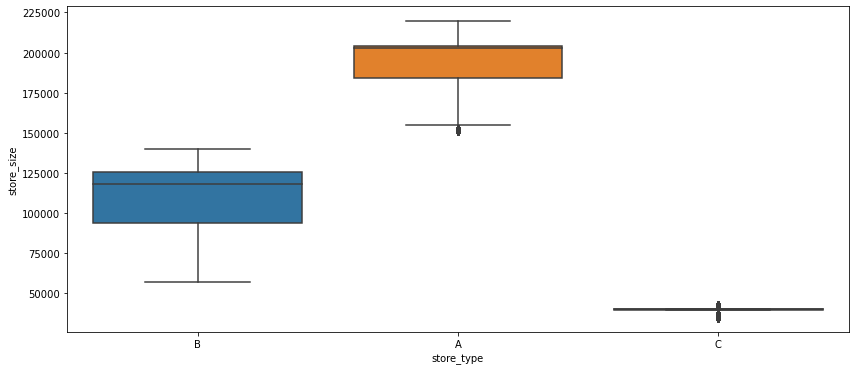

In [14]:
#visualize store_type by store_size
plt.figure(figsize=(14, 6))
sns.boxplot(x='store_type', y='store_size', data=train)

### Takeaways:
- Store A: appears to be only larger stores
- Store B: appear to be midsized stores
- Store C: appears to be only smaller stores

- outliers were addressed (store 3, store 5, store 33, store 36 were classified incorrectly)

<AxesSubplot:xlabel='store_type', ylabel='next_week_sales_target'>

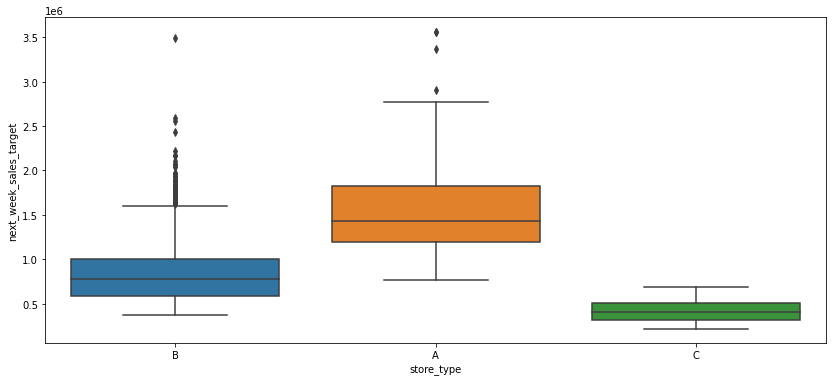

In [15]:
#visualize stores and weekly sales
plt.figure(figsize=(14,6))
sns.boxplot(x='store_type', y='next_week_sales_target', data=train)

<AxesSubplot:xlabel='store_type', ylabel='this_week_unemployment'>

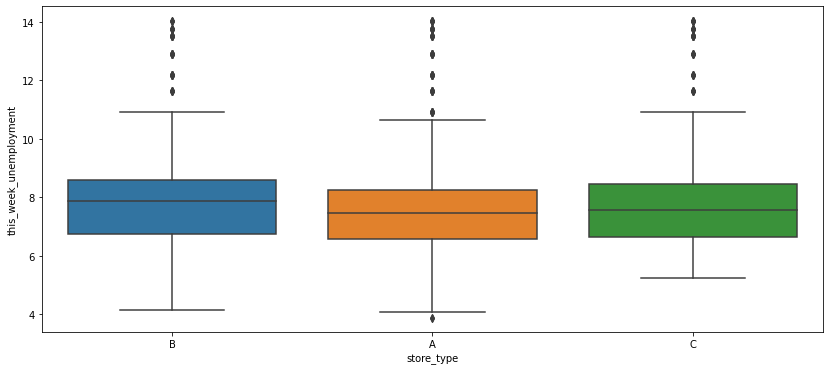

In [16]:
#visualize store type and unemployment rate
plt.figure(figsize=(14,6))
sns.boxplot(x='store_type', y='this_week_unemployment', data=train)

In [17]:
walmart = train.corr()
walmart

,this_week_sales,this_week_holiday_flag,this_week_unemployment,store_size,next_week_1_year_ago,next_week_sales_target,next_week_holiday_flag,christmas,labor_day,pre_christmas,super_bowl,thanksgiving
this_week_sales,1.000000,0.045091,-0.124278,0.822618,0.946883,0.962765,0.046326,0.140933,-0.013249,0.055363,0.000685,-0.010993
this_week_holiday_flag,0.045091,1.000000,-0.000009,-0.005686,-0.002272,0.000464,-0.071402,-0.027942,-0.041025,-0.039074,-0.040060,-0.027942
this_week_unemployment,-0.124278,-0.000009,1.000000,-0.071430,-0.097472,-0.123025,0.005452,-0.007507,-0.009426,0.012790,0.020026,0.005933
store_size,0.822618,-0.005686,-0.071430,1.000000,0.815440,0.826692,-0.002286,0.001808,-0.010166,-0.007689,0.009634,-0.006232
next_week_1_year_ago,0.946883,-0.002272,-0.097472,0.815440,1.000000,0.986895,0.022338,-0.018230,-0.007545,0.136609,0.012871,0.064786
next_week_sales_target,0.962765,0.000464,-0.123025,0.826692,0.986895,1.000000,0.035292,0.003227,-0.002386,0.112758,0.015225,0.063746
next_week_holiday_flag,0.046326,-0.071402,0.005452,-0.002286,0.022338,0.035292,1.000000,0.391336,0.574564,-0.039074,0.561053,0.391336
christmas,0.140933,-0.027942,-0.007507,0.001808,-0.018230,0.003227,0.391336,1.000000,-0.016055,-0.015291,-0.015677,-0.010935
labor_day,-0.013249,-0.041025,-0.009426,-0.010166,-0.007545,-0.002386,0.574564,-0.016055,1.000000,-0.022450,-0.023017,-0.016055
pre_christmas,0.055363,-0.039074,0.012790,-0.007689,0.136609,0.112758,-0.039074,-0.015291,-0.022450,1.000000,-0.021923,-0.015291


In [18]:
#this shows correlation with sales
wal_corr = walmart['next_week_sales_target'].sort_values(ascending=False)
wal_corr

next_week_sales_target    1.000000
next_week_1_year_ago      0.986895
this_week_sales           0.962765
store_size                0.826692
pre_christmas             0.112758
thanksgiving              0.063746
next_week_holiday_flag    0.035292
super_bowl                0.015225
christmas                 0.003227
this_week_holiday_flag    0.000464
labor_day                -0.002386
this_week_unemployment   -0.123025
Name: next_week_sales_target, dtype: float64

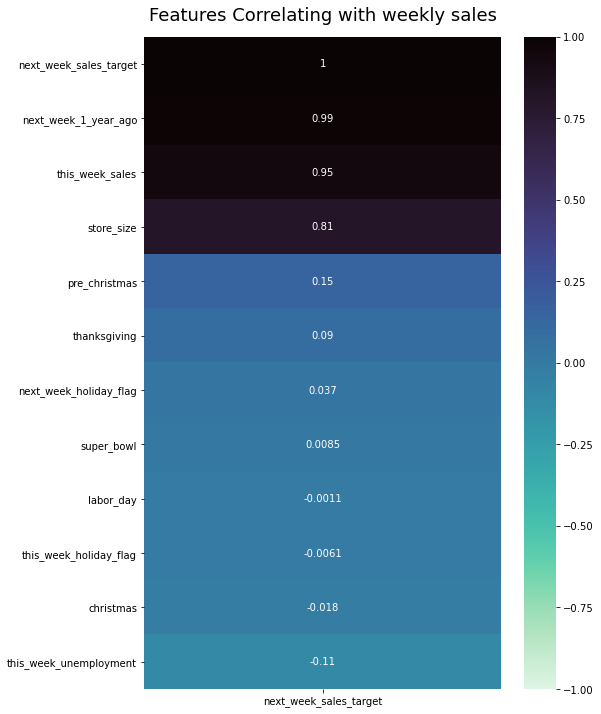

In [19]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['next_week_sales_target']].sort_values(by='next_week_sales_target', ascending=False), vmin=-1, vmax=1, annot=True, cmap='mako_r')
heatmap.set_title('Features Correlating with weekly sales', fontdict={'fontsize':18}, pad=16);

<hr style="border:2px solid black"> </hr>

## Hypothesis 1: Pearson's (cont vs cont)
$H_0$: There is no correlation between next week sales and store_size

$H_a$: There is a correlation between next week sales and store_size


In [20]:
#pearsons correlation on entire train set
#number of rows
n = train.shape[0] 

#degrees of freedom- how much the data can vary
deg_f = n-2 

#confidence interval (!)
conf_in = 0.95

alpha = 1- conf_in

In [21]:
x= train.next_week_sales_target
y= train.store_size

In [22]:
r, p = stats.pearsonr(x,y)
r,p

(0.8266920637985677, 0.0)

In [23]:
p < alpha

True

In [24]:
print(f'We calculate a pearson r of {r:3f} and a statistical certainty p of {p:4f}')
print(f'Because p {p:4f} < α  {alpha:4f}, we can reject our null hypothesis')

We calculate a pearson r of 0.826692 and a statistical certainty p of 0.000000
Because p 0.000000 < α  0.050000, we can reject our null hypothesis


### Takeaways:
- We rejected our null hypothesis, thus indicating that there is a correlation between next week sales and store size

<hr style="border:2px solid black"> </hr>

## Hypothesis 2: Pearson's (cont vs cont)
$H_0$: There is no correlation between this week sales and next week sales

$H_a$: There is a correlation between this week sales and next week sales

In [25]:
#pearsons correlation on entire train set
#number of rows
n = train.shape[0] 

#degrees of freedom- how much the data can vary
deg_f = n-2 

#confidence interval (!)
conf_in = 0.95

alpha = 1- conf_in

x= train.next_week_sales_target
y= train.this_week_sales

In [26]:
r, p = stats.pearsonr(x,y)
r,p

(0.9627654091073827, 0.0)

In [27]:
p < alpha

True

In [28]:
print(f'We calculate a pearson r of {r:3f} and a statistical certainty p of {p:4f}')
print(f'Because p {p:4f} < α  {alpha:4f}, we can reject our null hypothesis')

We calculate a pearson r of 0.962765 and a statistical certainty p of 0.000000
Because p 0.000000 < α  0.050000, we can reject our null hypothesis


### Takeaways:
- We rejected our null hypothesis, thus indicating that there is a correlation between this week sales and next week sales.

<hr style="border:2px solid black"> </hr>

# Modeling

In [32]:
df.dtypes

store_id                          object
this_week_date            datetime64[ns]
this_week_sales                  float64
this_week_holiday_flag             int64
this_week_unemployment           float64
store_type                        object
store_size                         int64
next_week_1_year_ago             float64
next_week_sales_target           float64
next_week_date            datetime64[ns]
next_week_holiday_flag           float64
next_week_holiday_name            object
christmas                          uint8
labor_day                          uint8
pre_christmas                      uint8
super_bowl                         uint8
thanksgiving                       uint8
dtype: object

In [37]:
train, test, X_train, y_train, X_test, y_test = w.train_test(df,'next_week_sales_target')

train -> (4504, 17)
test -> (1931, 17)


In [34]:
#train, test, X_train_scaled, X_test_scaled, y_train, y_test= w.split_scale(df, 'next_week_sales_target', scaler= MinMaxScaler())

In [ ]:
#set features
#we do not want to include all columns in this because it could cause overfitting
features = ['store_size', 'this_week_unemployment', 'next_week_1_year_ago', 'this_week_sales', 'pre_christmas']

In [ ]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame({'actual': y_train})
y_test = pd.DataFrame({'actual': y_test})

## Baseline

In [ ]:
#create the baseline using mean of all sales
baseline= y_train['actual'].mean()

In [ ]:
#create column called baseline to compare
y_train['baseline'] = baseline

In [ ]:
#calculate RMSE for baseline model
rmse_baseline_train= math.sqrt(mean_squared_error(y_train.actual, y_train.baseline))

In [ ]:
#create a dataframe to make data easier to visualize/understand
metric_df = pd.DataFrame(data=[{
    'model': "Baseline (using mean)",
    'rmse_train': round(rmse_baseline_train, 2),
    'r^2_validate': round(explained_variance_score(y_train.actual, y_train.baseline),4),

}])

metric_df

## Baseline 2

In [ ]:
#baseline version 2 using last years sales
baseline2 = train['last_year_sales']

In [ ]:
#prediction
#create column called baseline to compare
y_train['last_year_baseline'] = baseline2

In [ ]:
#calculate RMSE for baseline model
rmse_baseline2_train= math.sqrt(mean_squared_error(y_train.actual, y_train.last_year_baseline))

In [ ]:
#create a dataframe to make data easier to visualize/understand
metric_df = metric_df.append(
    {
    'model': "Baseline (using last year's sales)",
    'rmse_train': round(rmse_baseline2_train, 2),
    'r^2_validate': round(explained_variance_score(y_train.actual, y_train.last_year_baseline),4),
    }, ignore_index=True)

metric_df

## OLS Model

In [ ]:
#ordinary least squares
#create the model 
model1 = LinearRegression(normalize=True)

#fit the model
model1.fit(X_train[features], y_train.actual)

In [ ]:
# predict train
y_train['sales_pred_lm'] = model1.predict(X_train[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.actual, y_train.sales_pred_lm)**(1/2)

In [ ]:
#create visual to see baseline vs LinearRegression model
metric_df = metric_df.append(
    {
    'model': 'Model 1: OLS',
    'rmse_train': round(rmse_train, 2),
    'r^2_validate': round(explained_variance_score(y_train.actual, y_train.sales_pred_lm),4),
    }, ignore_index=True)

metric_df

## Lasso Lars

In [ ]:
# create the model object
model2 = LassoLars(alpha= 2)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
model2.fit(X_train[features], y_train.actual)

# predict train
y_train['sales_pred_lars'] = model2.predict(X_train[features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.actual, y_train.sales_pred_lars)**(1/2)

In [ ]:
#shows baseline vs LinearRegression vs LassoLars
metric_df = metric_df.append(
    {
    'model': 'Model 2: LassoLars (alpha 2)',
    'rmse_train': round(rmse_train,2),
    'r^2_validate': round(explained_variance_score(y_train.actual, y_train.sales_pred_lars),4),
    }, ignore_index=True)

metric_df

## Polynomial Regression

In [ ]:
#make the polynomial features to get a new set of features
model3 = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled features
X_train_degree2 = model3.fit_transform(X_train[features])

In [ ]:
#create the model
lm2 = LinearRegression(normalize=True)

#fit the mode
lm2.fit(X_train_degree2, y_train.actual)

#use the model
y_train['sale_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train_model3 = mean_squared_error(y_train.actual, y_train.sale_pred_lm2) ** (1/2)

In [ ]:
#shows baseline vs LinearRegression vs LassoLars
metric_df = metric_df.append(
    {
    'model': 'Model 3: Polynomial Regression (degree=2)',
    'rmse_train': round(rmse_train_model3,2),
    'r^2_validate': round(explained_variance_score(y_train.actual, y_train.sale_pred_lm2),4),
    }, ignore_index=True)

metric_df

### Takeaways
- 2nd Degree Polynomial Regression model out performed the baseline (using last year's sales) by 26.79% on the train set

<hr style="border:2px solid black"> </hr>

# Model on Scaled Data

In [ ]:
df_new = new_wrangle.wrangle_walmart()
train, test = new_wrangle.split_scale(df, 'weekly_sales')

In [ ]:
train, test, X_train_scaled, X_test_scaled, y_train, y_test = new_wrangle.split_scale(df_new, "weekly_sales", scaler= MinMaxScaler())